In [ ]:
attocube_moves = [0]
s = sched.scheduler(time.time, time.sleep)
for i in range(8):
    s.enter(3*3600*i, 1,tester,argument=(1250,))
s.run()

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import serial as serial
from pylablib.devices import Attocube
import time
from pyvisa import ResourceManager, constants
import pandas as pd

In [2]:
import datetime

In [3]:
import sched, time

In [4]:
from pyvisa.constants import StopBits, Parity

In [5]:
rm = ResourceManager()

In [16]:
rm.list_resources()

('ASRL4::INSTR',
 'ASRL5::INSTR',
 'ASRL6::INSTR',
 'ASRL8::INSTR',
 'ASRL9::INSTR')

In [ ]:
ANC150 = rm.open_resource('ASRL6::INSTR', write_termination='\n', read_termination='\n', baud_rate=38400, data_bits=8, parity=constants.Parity.none, stop_bits=constants.StopBits.one, flow_control=constants.VI_ASRL_FLOW_NONE)

In [18]:
atc1 = Attocube.ANC300("COM6") 

In [19]:
atc1.update_available_axes()

[1]

In [20]:
atc1.set_voltage(1,4)

AttocubeError: unexpected reply: getv 1
voltage = 4 V

In [21]:
atc1.enable_axis(axis = 1, mode='stp')

AttocubeError: unexpected reply: getm 1
mode = stp

In [29]:
atc1.move_by(axis=1,steps=-1000)

In [8]:
def cap_meas(N):
    f_sample = 10 #cannot change this, fixed parameter in hardware, it only samples at this frequency
    T_sample = 1/f_sample #for cap sensor, measurement freq is fixed at 10Hz

    #print(f"Measurement time: {N*T_sample:.1f}s")

    t = np.linspace(0.1,N*T_sample,N)


    port = serial.Serial('COM8',115200,timeout=1.05*N*T_sample,parity=serial.PARITY_NONE,rtscts=1) #make serial connection to the device and get samples
    V_measure = port.read(int(8*N))
    port.close()

    #conert data to numpy array with floats
    data = str(V_measure)
    data = data.split("\\r\\n")

    data[0] = data[0][2:]
    data = data[:-1]

    D = np.array([float(x) for x in data])
    avg = np.mean(D)
    std = np.std(D)
    
    #print("Measurement Done!")
    return t,D,avg,std

In [9]:
def plot_cap_meas(t,D):
    fig,ax = plt.subplots(1,1)

    ax.plot(t,D)
    ax.grid(True)
    ax.set_xlabel("t [s]")
    ax.set_ylabel("amplitude [mV]")
    return

In [10]:
def attocube_mover(steps):
    atc1.move_by(axis = 1, steps = steps)
    #attocube_moves.append(steps)
    #counter = counter
    #counter += 1
    #time.append(counter)
    return 

In [11]:
def back_and_forth(axis,steps,N):
    pre_t,pre_D,pre_avg,std = cap_meas(N)
    cap_mean.append(pre_avg)
    attocube_mover(steps)
    mid_t,mid_D,mid_avg,std = cap_meas(N)
    cap_mean.append(mid_avg)
    attocube_mover(steps)
    post_t,post_D,post_avg,std = cap_meas(N)
    cap_mean.append(post_avg)
    delta = post_avg - pre_avg
    return pre_avg,mid_avg,post_avg

In [51]:
atc1.move_by(1,-1000)

In [52]:
cap_meas(10)

(array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 array([336.08, 336.03, 336.04, 336.06, 336.02, 336.02, 336.04, 336.04,
        336.06, 336.09]),
 336.048,
 0.02271563338319895)

In [50]:
def walk(axis,steps,f_actions,b_actions,N):
    cap_meanloc = []
    cap_stdloc = []
    T_listloc = []
    for i in range(f_actions):
        attocube_mover(steps = steps)
        pre_t,pre_D,avg,std = cap_meas(N)
        cap_meanloc.append(avg)
        cap_stdloc.append(std)
        T_listloc.append(float(tempsensor.query("KRDG? 3")))
        if avg < 310:
            print("Reached Positive Edge")
            break
    for i in range(b_actions): 
        attocube_mover(steps =-steps)
        pre_t,pre_D,avg,std = cap_meas(N)
        cap_meanloc.append(avg)
        cap_stdloc.append(std)
        T_listloc.append(float(tempsensor.query("KRDG? 3")))
        if avg > 334:
            print("Reached Negative Edge")
            break
    print("Walk Done!")
    return cap_meanloc,cap_stdloc,T_listloc

In [53]:
tempsensor = rm.open_resource('ASRL9::INSTR',write_termination="\r\n",read_termination="\r\n",baud_rate=9600,data_bits=7,parity=Parity.odd,stop_bits=StopBits.one)

In [54]:
tempsensor.query("KRDG? 3")

'+26.264'

In [87]:
atc1.move_by(1,-1000)

In [59]:
tester(3000)

Frequency 3000
Voltage 4


KeyboardInterrupt: 

In [80]:
atc1.move_by(1,-1000)

In [58]:
def tester(frequency):
    amp = 50



    for j in range(1):
        
        voltage = 4
        f_actions = 400
        b_actions = 400
        temp = 0
        try:
            temp = tempsensor.query("KRDG? 3")
        except:
            print("Could not read temperature sensor")
        
        try:
            atc1.set_frequency(axis=1,freq=frequency)
        except:
            print(f"Frequency {frequency}")
        
        




        for i in range(1):   
            attocube_moves = [0]
            ti = [0]
            counter = [0]
            cap_mean = []
            cap_std = []
            T_list = []
            try:
                atc1.set_voltage(axis=1,voltage=voltage)
            except:
                print(f"Voltage {voltage}")

            load = 0
            cable_length = 200
            
            temporal = time.strftime("%Y%m%d_%H%M%S")

            stepsize = 500
            
            samples = 10

            pre_t,pre_D,avg,std = cap_meas(samples)
            cap_mean.append(avg)
            cap_std.append(std)
            T_list.append(float(tempsensor.query("KRDG? 3")))
            c,s,T = walk(1,stepsize,f_actions,b_actions,samples)
            cap_mean += c
            cap_std += s
            T_list += T
            displacement = (np.array(cap_mean)-cap_mean[0])/7.215116279069762
            t = range(len(cap_mean))
            d = {'actions': t, 'capacitance': cap_mean,'displacement': displacement,'error': cap_std,'temperature':T_list}
            df = pd.DataFrame(data=d)
            df.to_csv(f'Atc_newamp02_data/{stepsize}walk_{temporal}_{load}g_{frequency}Hz_{temp}K_{voltage*amp}V.csv')

            std = np.array(std)

            fig, ax1 = plt.subplots(1, 1)
            ax2 = ax1.twinx()
            ax2.errorbar(t[1:],displacement[1:],yerr=(std/7.215116279069762),fmt='.',visible = False,mfc='red')
            ax2.set_xlabel("Action")
            ax2.set_ylabel("Displacement [mm]")

            ax2.set_title(f"{load}g {voltage}V stepsize = {stepsize} {frequency}Hz")
            ax1.errorbar(t[1:],cap_mean[1:],yerr=std,fmt='.')
            ax1.grid(True)
            ax1.set_xlabel("Action")
            ax1.set_ylabel("Capacitive Amplitude [mV]")
            ax1.set_title(f"{load}g {voltage}V stepsize = {stepsize} {frequency}Hz")

            fig.savefig(f"Atc_newamp02_figures/{stepsize}walk_{temporal}_{load}g_{frequency}Hz_{temp}K_{voltage*amp}V.png",dpi=150)

            """for i in np.append([1],np.arange(2,4,2)):
                attocube_moves = [0]
                ti = [0]
                counter = [0]
                cap_mean = []
                cap_std = []
                T_list = []
                c,s,T = walk(1,i,200,200,4)
                cap_mean += c
                cap_std += s
                T_list +=T
                displacement = (np.array(cap_mean)-cap_mean[0])/7.215116279069762
                t = range(len(cap_mean))
                d = {'actions': t, 'capacitance': cap_mean,'displacement': displacement,'error': cap_std,'temperature':T_list}
                df = pd.DataFrame(data=d)
                df.to_csv(f'Atc_newamp_data/{i}singlesteps_{temporal}_{load}g_{frequency}Hz_{temp}K_{voltage*amp}V.csv')
"""





            #f_actions += 50
            #b_actions += 50
            #voltage -= 5
            
        frequency += 250

In [30]:
t = range(len(cap_mean))
T_list = t
d = {'actions': t, 'capacitance': cap_mean,'displacement': displacement,'error': cap_std,'temperature':T_list}
df = pd.DataFrame(data=d)
df.to_csv(f'Atc_Amp_data/walk_{temporal}_{load}g_{frequency}Hz_{temp}K_{voltage}V.csv')

std = np.array(std)

fig, ax1 = plt.subplots(1, 1)
ax2 = ax1.twinx()
ax2.errorbar(t[1:],displacement[1:],yerr=(std/7.215116279069762),fmt='.',visible = False,mfc='red')
ax2.set_xlabel("Action")
ax2.set_ylabel("Displacement [mm]")

ax2.set_title(f"{load}g {voltage}V stepsize = {stepsize} {frequency}Hz")
ax1.errorbar(t[1:],cap_mean[1:],yerr=std,fmt='.')
ax1.grid(True)
ax1.set_xlabel("Action")
ax1.set_ylabel("Capacitive Amplitude [mV]")
ax1.set_title(f"{load}g {voltage}V stepsize = {stepsize} {frequency}Hz")

fig.savefig(f"Atc_Amp_figures/walk_{temporal}_{load}g_{frequency}Hz_{temp}K_{voltage}V.png",dpi=150)

#for i in np.append([1],np.arange(2,6,2)):
#    attocube_moves = [0]
#    ti = [0]
#    counter = [0]
#    cap_mean = []
#    cap_std = []
#    T_list = []
#    c,s,T = walk(1,i,200,200,4)
#    cap_mean += c
#    cap_std += s
#    T_list += T
#    displacement = (np.array(cap_mean)-cap_mean[0])/7.215116279069762
#    t = range(len(cap_mean))
#    d = {'actions': t, 'capacitance': cap_mean,'displacement': displacement,'error': cap_std,'temperature':T_list}
#    df = pd.DataFrame(data=d)
#    df.to_csv(f'Atc_cooldown02_data/{i}singlesteps_{temporal}_{load}g_{frequency}Hz_{temp}K_{voltage}V.csv')



NameError: name 'cap_mean' is not defined

In [61]:
atc1.close()

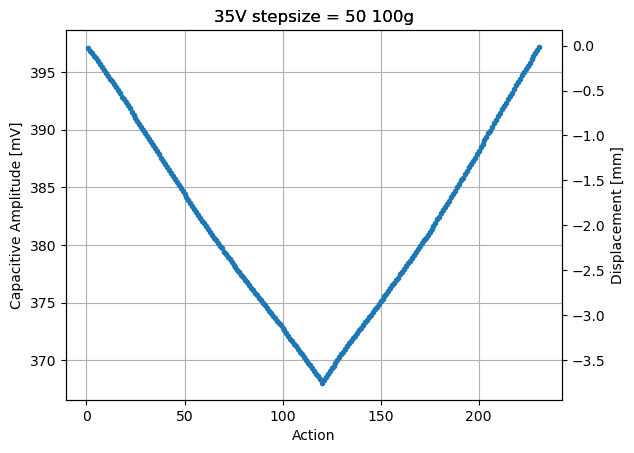

In [352]:
fig, ax1 = plt.subplots(1, 1)
ax2 = ax1.twinx()
ax2.errorbar(t[1:],displacement[1:],yerr=(std/7.215116279069762),fmt='.',visible = False,mfc='red')
ax2.set_xlabel("Action")
ax2.set_ylabel("Displacement [mm]")

ax2.set_title(f"{voltage}V stepsize = {stepsize} {load}g")
ax1.errorbar(t[1:],cap_mean[1:],yerr=std,fmt='.')
ax1.grid(True)
ax1.set_xlabel("Action")
ax1.set_ylabel("Capacitive Amplitude [mV]")
ax1.set_title(f"{voltage}V stepsize = {stepsize} {load}g")

fig.savefig(f"Atc_walk_figures_{load}g/S{stepsize}_N{samples}_V{voltage}_A{f_actions+b_actions}")

In [267]:
atc1.close()

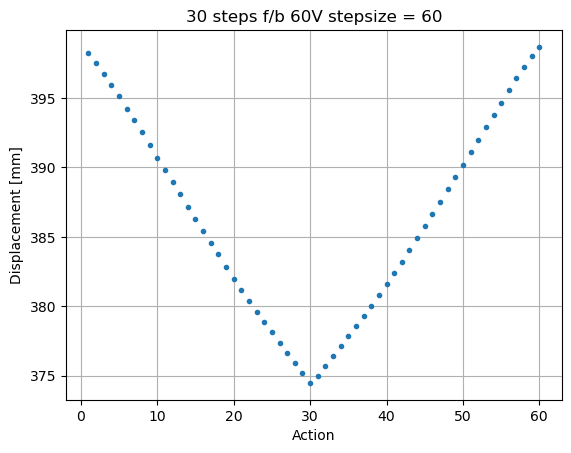

In [215]:
fig,ax = plt.subplots(1,1)

ax.plot(t[1:],cap_mean[1:],'.')
ax.grid(True)
ax.set_xlabel("Action")
ax.set_ylabel("Displacement [mm]")
ax.set_title(f"{f_actions} steps f/b {voltage}V stepsize = {stepsize}")
fig.savefig(f"S{stepsize}_N{samples}_V{voltage}_A{f_actions+b_actions}")

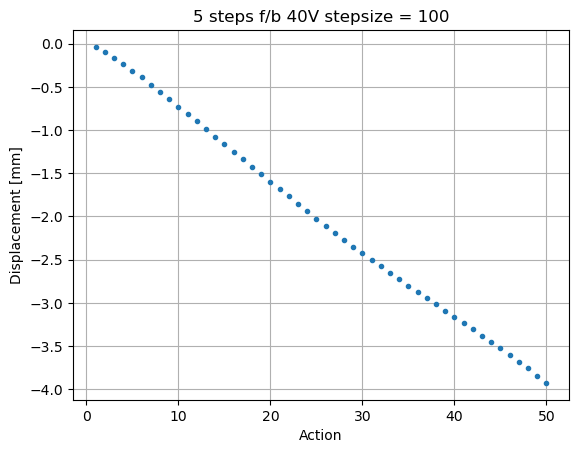

In [198]:
fig,ax = plt.subplots(1,1)
ax.plot(t[1:],displacement[1:],'.')
ax.grid(True)
ax.set_xlabel("Action")
ax.set_ylabel("Displacement [mm]")
ax.set_title("5 steps f/b 40V stepsize = 100")
fig.savefig(f"S{stepsize}_N{samples}_V{voltage}_A{f_actions+b_actions}")

In [81]:
t = range(41)

In [176]:
d = {'actions': dlist, 'capacitance': capacitances}
df = pd.DataFrame(data=d)

In [177]:
df.to_csv("Calibrationdatareal")

In [23]:
atc1.close()

In [16]:
pd.DataFrame(t,cap_mean,attocube_moves,columns=["actions","capacitance","moves"])

TypeError: __init__() got multiple values for argument 'columns'

In [166]:
cap_a = np.array(cap_mean)
cap_a = (cap_a-par[1])/par[0]

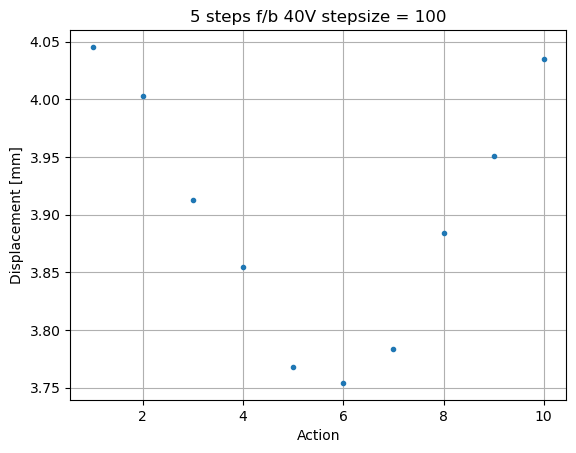

In [170]:
fig,ax = plt.subplots(1,1)

ax.plot(t[1:],cap_a[1:],'.')
ax.grid(True)
ax.set_xlabel("Action")
ax.set_ylabel("Displacement [mm]")
ax.set_title("5 steps f/b 40V stepsize = 100")
fig.savefig(f"S{stepsize}_N{samples}_V{voltage}")

In [172]:
atc1.close()

In [59]:
t = range(11)

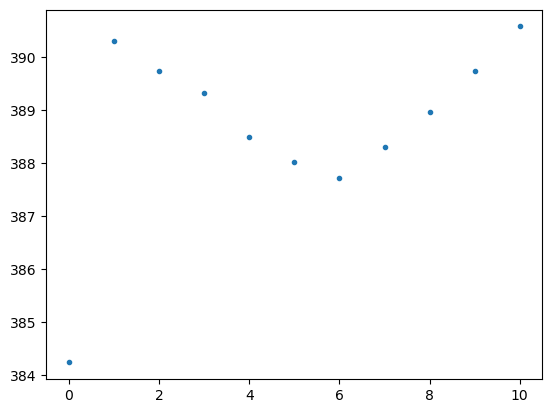

In [61]:
plt.plot(t,cap_mean,'.')

In [57]:
print(cap_mean)

[384.241, 390.307, 389.738, 389.325, 388.491, 388.02799999999996, 387.722, 388.308, 388.967, 389.73900000000003, 390.581]


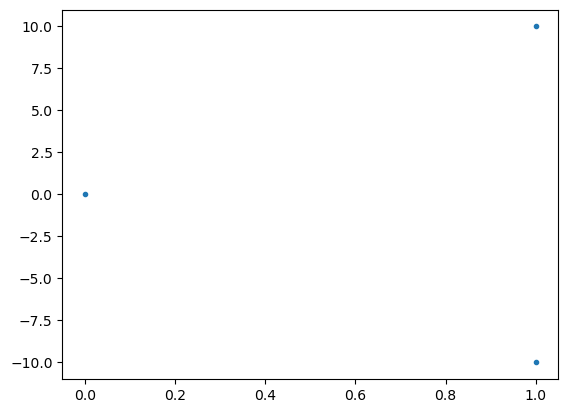

In [34]:
plt.plot(attocube_mov,'.')

In [ ]:
plt.plot(time,cap_mean)

In [ ]:
data_a = []

In [11]:
t,D,a = cap_meas(10)
data_a.append(a)

Measurement time: 1.0s
Measurement Done!
502.591


In [12]:
t,D,a = cap_meas(10)
print(a)

Measurement time: 1.0s
Measurement Done!
501.41099999999994


In [13]:
t,D,a = cap_meas(10)
print(a)

Measurement time: 1.0s
Measurement Done!
503.10800000000006


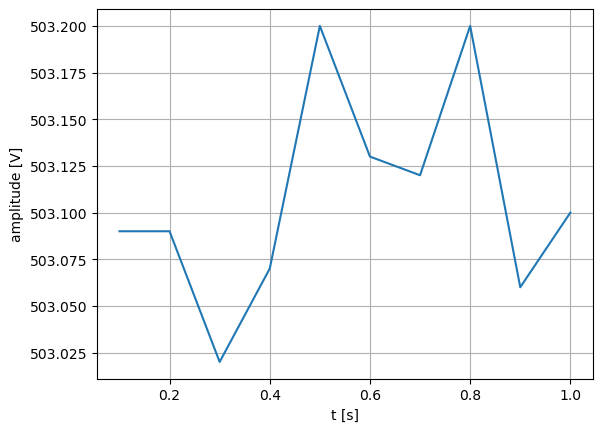

In [14]:
plot_cap_meas(t,D)

In [ ]:
t,D,a = cap_meas(10)
print(a)

In [13]:
back_and_forth(1,10,10)

Measurement time: 180.0s


In [12]:
atc1.close()

In [43]:
capacitances = []
distance = 0
dlist = []

In [149]:
atc1.move_by(axis = 1, steps=-100)

In [148]:

a,b,c = cap_meas(10)
capacitances.append(c)
dlist.append(4.343)

Measurement time: 1.0s
Measurement Done!


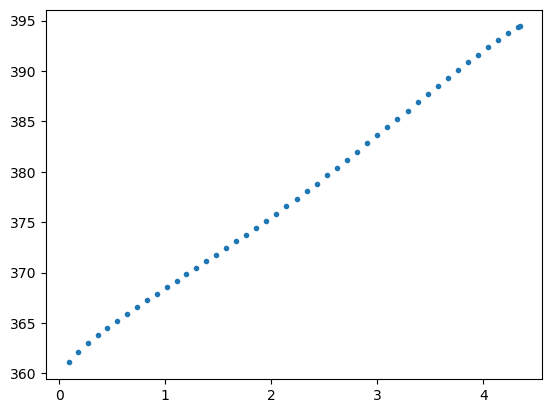

In [152]:
plt.plot(dlist[1:],capacitances[1:],'.')

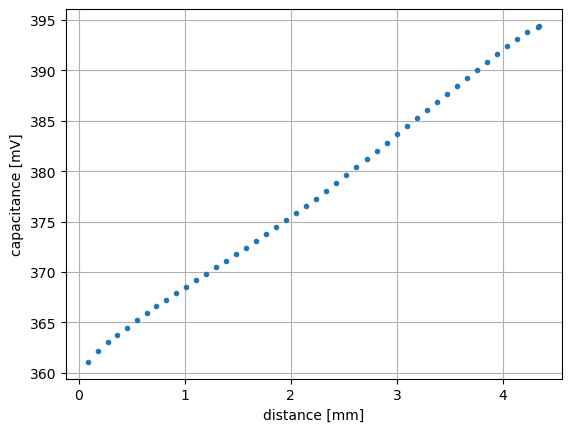

In [168]:
fig,ax = plt.subplots(1,1)

ax.plot(dlist[1:],capacitances[1:],'.')
ax.grid(True)
ax.set_xlabel("distance [mm]")
ax.set_ylabel("capacitance [mV]")
fig.savefig(f"Calibration")

In [154]:
def lin(x,a,b):
    return a*x + b

In [157]:
from scipy.optimize import curve_fit
par,cov = curve_fit(lin,dlist[1:],capacitances[1:])

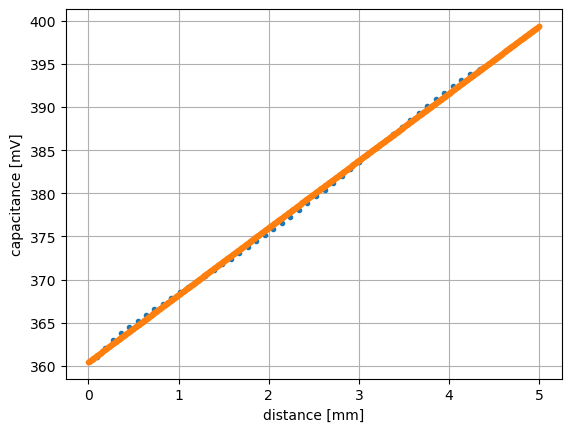

In [169]:
X = np.linspace(0,5,1000)
Y = lin(X,*par)
fig,ax = plt.subplots(1,1)

ax.plot(dlist[1:],capacitances[1:],'.')
ax.plot(X,Y,'.')
ax.grid(True)
ax.set_xlabel("distance [mm]")
ax.set_ylabel("capacitance [mV]")
fig.savefig(f"Calibrationwithfit")

In [160]:
par

array([  7.78625285, 360.46155391])

In [145]:
capacitances

[338.16900000000004,
 361.074,
 362.124,
 363.003,
 363.794,
 364.486,
 365.21000000000004,
 365.91,
 366.588,
 367.22599999999994,
 367.89,
 368.55,
 369.199,
 369.843,
 370.46999999999997,
 371.121,
 371.785,
 372.42900000000003,
 373.094,
 373.774,
 374.459,
 375.14000000000004,
 375.844,
 376.559,
 377.27699999999993,
 378.07399999999996,
 378.827,
 379.63399999999996,
 380.394,
 381.166,
 381.995,
 382.834,
 383.655,
 384.446,
 385.254,
 386.044,
 386.901,
 387.67099999999994,
 388.508,
 389.279,
 390.071,
 390.878,
 391.635,
 392.418,
 393.111,
 393.779,
 394.34000000000003]

In [146]:
dlist

[0,
 0.091,
 0.181,
 0.272,
 0.364,
 0.455,
 0.546,
 0.639,
 0.732,
 0.825,
 0.919,
 1.012,
 1.106,
 1.2,
 1.294,
 1.387,
 1.482,
 1.576,
 1.671,
 1.765,
 1.859,
 1.954,
 2.048,
 2.143,
 2.238,
 2.333,
 2.428,
 2.524,
 2.618,
 2.714,
 2.809,
 2.905,
 3,
 3.094,
 3.189,
 3.285,
 3.38,
 3.475,
 3.568,
 3.663,
 3.757,
 3.852,
 3.947,
 4.041,
 4.136,
 4.231,
 4.326]